# Tunnel+

The overall goal of this notebook is to create a new statistic called Tunnel+ that can measure how well a pitcher is tunneling their pitches.

In [1]:
from pybaseball.plotting import plot_strike_zone
import matplotlib.pyplot as plt
import polars as pl
import numpy as np

### Reading data

The data for this project is located in [this hugging face space](https://huggingface.co/datasets/Jensen-holm/statcast-era-pitches) that I made. It contains every single pitch from the modern statcast era up through last year (2015-2023).

In [2]:
STATCAST_ERA_PITCHES_URL: str = (
    "https://huggingface.co/api/datasets/Jensen-holm/statcast-era-pitches/parquet/default/train/0.parquet"
)

statcast_era_df: pl.DataFrame = pl.read_parquet(STATCAST_ERA_PITCHES_URL)
print(statcast_era_df.sample(3))

shape: (3, 92)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ pitch_typ ┆ game_date ┆ release_s ┆ release_p ┆ … ┆ of_fieldi ┆ spin_axis ┆ delta_hom ┆ delta_ru │
│ e         ┆ ---       ┆ peed      ┆ os_x      ┆   ┆ ng_alignm ┆ ---       ┆ e_win_exp ┆ n_exp    │
│ ---       ┆ str       ┆ ---       ┆ ---       ┆   ┆ ent       ┆ f32       ┆ ---       ┆ ---      │
│ str       ┆           ┆ f32       ┆ f32       ┆   ┆ ---       ┆           ┆ f32       ┆ f32      │
│           ┆           ┆           ┆           ┆   ┆ str       ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ FC        ┆ 2019-07-0 ┆ 87.599998 ┆ -1.68     ┆ … ┆ Standard  ┆ 175.0     ┆ 0.027     ┆ 0.391    │
│           ┆ 6 00:00:0 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 0.0000000 ┆           ┆           ┆   ┆           ┆           

# Pre-Processing

***Goal***
Reverse the magnus effect on the baseball for each pitch so that we can estimate where the ball would have ended up without spin induced magnus force. This will allow us to measure how well hte pitcher is tunneling their pitches because if two pitches end up in similar positions without spin, but end up far apart, the pitch was pretty elusive and was in likley appeared to like the other pitch.

In [3]:
# remove rows where columns we are interested in are null
statcast_era_pitches = statcast_era_df.drop_nulls(
    subset=[
        "pitch_type",  # type of pitch: FF, FC, CU, etc ...
        "release_pos_x",  # horizontal release position of ball in ft from catcher pov
        "release_pos_z",  # vertical release position of ball in ft from catcher pov
        "spin_axis",
        "pfx_x",  # horizontal movement in ft from catchers perspective
        "pfx_z",  # vertical movement in ft from catchers perspective
        "plate_x",  # horizontal position of ball when it crossed the plate
        "plate_z",  # vertical position of the ball when it crossed the plate
        "release_speed",
    ]
)

## Reversing Ball Movement

In [4]:
# add columns for the ball's position if it had no movement
statcast_era_pitches = statcast_era_pitches.with_columns(
    plate_x_no_move=pl.col("plate_x") - pl.col("pfx_x"),
    plate_z_no_move=pl.col("plate_z") - pl.col("pfx_z"),
)

print(statcast_era_pitches.sample(3, seed=1).select([
    "plate_x",
    "plate_z",
    "pfx_x",
    "pfx_z",
    "plate_x_no_move",
    "plate_z_no_move",
]))

shape: (3, 6)
┌─────────┬─────────┬───────┬───────┬─────────────────┬─────────────────┐
│ plate_x ┆ plate_z ┆ pfx_x ┆ pfx_z ┆ plate_x_no_move ┆ plate_z_no_move │
│ ---     ┆ ---     ┆ ---   ┆ ---   ┆ ---             ┆ ---             │
│ f32     ┆ f32     ┆ f32   ┆ f32   ┆ f32             ┆ f32             │
╞═════════╪═════════╪═══════╪═══════╪═════════════════╪═════════════════╡
│ -0.65   ┆ 2.6     ┆ -1.04 ┆ 0.69  ┆ 0.39            ┆ 1.91            │
│ 0.31    ┆ 2.41    ┆ 0.4   ┆ 0.21  ┆ -0.09           ┆ 2.2             │
│ 1.31    ┆ 3.31    ┆ 0.17  ┆ 0.7   ┆ 1.14            ┆ 2.61            │
└─────────┴─────────┴───────┴───────┴─────────────────┴─────────────────┘


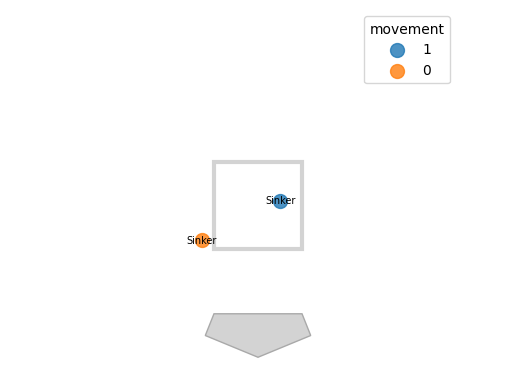

In [5]:

# visualize the difference for a single random pitch
random_pitch = statcast_era_pitches.sample(1, seed=3).select(
    "pitch_type",
    "pitch_name",
    "plate_x",
    "plate_z",
    "plate_x_no_move",
    "plate_z_no_move",
)

plot_strike_zone(
    data=(pl.concat([
        random_pitch.select("pitch_type", "pitch_name", "plate_x", "plate_z").with_columns(
            movement=1,
        ),
        random_pitch.select("pitch_type", "pitch_name", "plate_x_no_move", "plate_z_no_move").rename({
            "plate_z_no_move": "plate_z",
            "plate_x_no_move": "plate_x",
        }).with_columns(movement=0),
    ])).to_pandas(),
    colorby="movement",
    annotation="pitch_name",
)

plt.show()

## Appending Previous pitches

In [7]:
# sort the dataframe to make sure that each pitch is next to the previous one,
# then, add new columns to the dataframe that contain the previous pitches information. 
statcast_era_pitches_sorted = statcast_era_pitches.sort(
    by=["game_date", "at_bat_number", "pitch_number"],
    descending=False,
)

for col_name in statcast_era_pitches_sorted.columns:
    statcast_era_pitches_sorted = statcast_era_pitches_sorted.with_columns(
        pl.col(col_name).shift(-1).over("pitcher").alias(f"prev_{col_name}")
    )

In [8]:
statcast_era_pitches_sorted = statcast_era_pitches_sorted.drop_nulls(subset=[
    "prev_plate_x",
    "prev_plate_z",
])

In [9]:
print(statcast_era_pitches_sorted.select(
    "prev_release_pos_x",
    "prev_plate_x",
    "prev_plate_x_no_move",
).sample(3))

shape: (3, 3)
┌────────────────────┬──────────────┬──────────────────────┐
│ prev_release_pos_x ┆ prev_plate_x ┆ prev_plate_x_no_move │
│ ---                ┆ ---          ┆ ---                  │
│ f32                ┆ f32          ┆ f32                  │
╞════════════════════╪══════════════╪══════════════════════╡
│ 2.15               ┆ 0.08         ┆ 0.36                 │
│ -1.71              ┆ -0.24        ┆ -1.65                │
│ 1.54               ┆ 0.12         ┆ 0.39                 │
└────────────────────┴──────────────┴──────────────────────┘


## Compute Distances with Previous Pitch

By computing the euclidean distances between where the current pitch ended up, where it would have ended up without movement with that of the previous pitch, we can see if they were on a similar trajectory during hte ball flight. This can give us an idea of how well the pitches are 'tunneling'.

In [10]:

def euclidean_distance(point1: tuple[float, float], point2: tuple[float, float]) -> float:
    x1, y1 = point1
    x2, y2 = point2
    return np.sqrt(((x1 - x2) ** 2) + ((y1 - y2) ** 2))


distances_df: pl.DataFrame = statcast_era_pitches_sorted.with_columns(
    # euclidean distance between the actual x and z coordinates of the pitch and the previous one
    distance=euclidean_distance(
        point1=(pl.col("plate_x"), pl.col("plate_z")),
        point2=(pl.col("prev_plate_x"), pl.col("prev_plate_z")),
    ),

    # euclidean distance between the x and z coordinates of the pitch and the previous one if they had no movement
    distance_no_movement=euclidean_distance(
        point1=(pl.col("plate_x_no_move"), pl.col("plate_z_no_move")),
        point2=(pl.col("prev_plate_x_no_move"), pl.col("prev_plate_x_no_move")),
    )
) 

print(distances_df.select(
    "distance_no_movement",
    "distance",
).sample(3, seed=42))

shape: (3, 2)
┌──────────────────────┬──────────┐
│ distance_no_movement ┆ distance │
│ ---                  ┆ ---      │
│ f32                  ┆ f32      │
╞══════════════════════╪══════════╡
│ 1.945585             ┆ 0.860523 │
│ 4.486123             ┆ 0.76922  │
│ 0.940053             ┆ 0.54     │
└──────────────────────┴──────────┘


# Find pitches with little distance_no_movement

In [12]:
# sort the dataframe by the distance column in ascending order
distances_df_sorted = distances_df.sort("distance", descending=False)

print(distances_df_sorted)

shape: (4_679_491, 190)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ pitch_typ ┆ game_date ┆ release_s ┆ release_p ┆ … ┆ prev_plat ┆ prev_plat ┆ distance  ┆ distance │
│ e         ┆ ---       ┆ peed      ┆ os_x      ┆   ┆ e_x_no_mo ┆ e_z_no_mo ┆ ---       ┆ _no_move │
│ ---       ┆ str       ┆ ---       ┆ ---       ┆   ┆ ve        ┆ ve        ┆ f32       ┆ ment     │
│ str       ┆           ┆ f32       ┆ f32       ┆   ┆ ---       ┆ ---       ┆           ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆ f32       ┆ f32       ┆           ┆ f32      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ CH        ┆ 2016-04-1 ┆ 86.900002 ┆ -2.22     ┆ … ┆ -0.03     ┆ 1.24      ┆ 0.0       ┆ 1.378296 │
│           ┆ 9 00:00:0 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 0.0000000 ┆           ┆           ┆   ┆           ┆  